<a href="https://colab.research.google.com/github/rlberry-py/rlberry/blob/main/notebooks/introduction_to_rlberry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to
<img src="https://raw.githubusercontent.com/rlberry-py/rlberry/main/assets/logo_wide.svg" width="700"/>




# Colab setup

In [1]:
from IPython import get_ipython
COLAB = False
if 'google.colab' in str(get_ipython()):
    COLAB = True

if COLAB:
    # install rlberry library
    !git clone https://github.com/rlberry-py/rlberry.git 
    !cd rlberry && git pull && pip install -e . > /dev/null 2>&1

    # install ffmpeg-python for saving videos
    !pip install ffmpeg-python > /dev/null 2>&1

    # install optuna for hyperparameter optimization
    !pip install optuna > /dev/null 2>&1

    # packages required to show video
    !pip install pyvirtualdisplay > /dev/null 2>&1
    !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

    print("")
    print(" ~~~  Libraries installed, please restart the runtime! ~~~ ")
    print("")


In [2]:
# Create directory for saving videos
!mkdir videos > /dev/null 2>&1

# Initialize display and import function to show videos
import rlberry.colab_utils.display_setup
from rlberry.colab_utils.display_setup import show_video

/bin/bash: /home/omardd/miniconda3/envs/rlberry/lib/libtinfo.so.6: no version information available (required by /bin/bash)


# Interacting with a simple environment

In [3]:
from rlberry.envs import GridWorld

# A grid world is a simple environment with finite states and actions, on which 
# we can test simple algorithms.
# -> The reward function can be accessed by: env.R[state, action]
# -> And the transitions: env.P[state, action, next_state]
env_ctor = GridWorld
env_kwargs =dict(nrows=3, ncols=10,
                reward_at = {(1,1):0.1, (2, 9):1.0},
                walls=((1,4),(2,4), (1,5)),
                success_probability=0.9)
env = env_ctor(**env_kwargs)

# Let's visuzalize a random policy in this environment!
env.enable_rendering()
env.reset()
for tt in range(20):
    action = env.action_space.sample()
    next_state, reward, is_terminal, info = env.step(action)

# save video and clear buffer
env.save_video('./videos/gw.mp4', framerate=5)
env.clear_render_buffer()
# show video
show_video('./videos/gw.mp4')

[INFO] OpenGL_accelerate module loaded 
[INFO] Using accelerated ArrayDatatype 
ffmpeg: /home/omardd/miniconda3/envs/rlberry/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/omardd/miniconda3/envs/rlberry/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/omardd/miniconda3/envs/rlberry/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable

# Creating an agent

Let's create an agent that runs value iteration to find a near-optimal policy.
This is possible in our GridWorld, because we have access to the transitions `env.P` and the rewards `env.R`.


An `Agent` must implement at least two methods, **fit()** and **eval()**. These methods train and evaluate the agent, respectively. A convenient subclass of `Agent`, `AgentWithSimplePolicy`, requires a **policy()** method instead of **eval()** and implements a default `eval()` method that performs Monte-Carlo policy evaluation.

It can also implement **sample_parameters()** used for hyperparameter optimization with [Optuna](https://optuna.org/).


In [4]:
import numpy as np
from rlberry.agents import AgentWithSimplePolicy

class ValueIterationAgent(AgentWithSimplePolicy):
    name = 'ValueIterationAgent'
    def __init__(self, env, gamma=0.99, epsilon=1e-5, **kwargs):   # it's important to put **kwargs to ensure compatibility with the base class 
        """
        gamma: discount factor
        episilon: precision of value iteration
        """
        AgentWithSimplePolicy.__init__(self, env, **kwargs) # self.env is initialized in the base class

        self.gamma = gamma
        self.epsilon = epsilon 
        self.Q = None  # Q function to be computed in fit()
    
    def fit(self, budget=None, **kwargs):  
        """
        Run value iteration.
        """
        S, A = env.observation_space.n, env.action_space.n 
        Q = np.zeros((S, A))
        V = np.zeros(S)

        while True:
            TQ = np.zeros((S, A))
            for ss in range(S):
                for aa in range(A):
                    TQ[ss, aa] = env.R[ss, aa] + self.gamma*env.P[ss, aa, :].dot(V)
            V = TQ.max(axis=1)

            if np.abs(TQ-Q).max() < self.epsilon:
                break
            Q = TQ
        self.Q = Q
          
    def policy(self, observation):
        return self.Q[observation, :].argmax()

    
    @classmethod
    def sample_parameters(cls, trial):
      """
      Sample hyperparameters for hyperparam optimization using Optuna (https://optuna.org/)
      """
      gamma = trial.suggest_categorical('gamma', [0.1, 0.25, 0.5, 0.75, 0.99])
      return {'gamma':gamma}


In [5]:
# Now, let's fit and test the agent!
agent = ValueIterationAgent(env)
agent.fit()


# Run agent's policy
env.enable_rendering()
state = env.reset()
for tt in range(20):
    action = agent.policy(state)
    state, reward, is_terminal, info = env.step(action)

# save video and clear buffer
env.save_video('./videos/gw.mp4', framerate=5)
env.clear_render_buffer()
# show video
show_video('./videos/gw.mp4')


ffmpeg: /home/omardd/miniconda3/envs/rlberry/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/omardd/miniconda3/envs/rlberry/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/omardd/miniconda3/envs/rlberry/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite 

# `AgentManager`: A powerfull class for hyperparameter optimization, training and evaluating agents.

In [6]:
# Create random agent as a baseline
class RandomAgent(AgentWithSimplePolicy):
    name = 'RandomAgent'
    def __init__(self, env, gamma=0.99, epsilon=1e-5, **kwargs):   # it's important to put **kwargs to ensure compatibility with the base class 
        """
        gamma: discount factor
        episilon: precision of value iteration
        """
        AgentWithSimplePolicy.__init__(self, env, **kwargs) # self.env is initialized in the base class

    def fit(self, budget=None, **kwargs):  
        pass
          
    def policy(self, observation):
        return self.env.action_space.sample()

[INFO] Training AgentManager for ValueIterationAgent...  
[INFO] Sucessful call to AgentHandler.dump() for <class '__main__.ValueIterationAgent'> 
[INFO] Sucessful call to AgentHandler.dump() for <class '__main__.ValueIterationAgent'> 
[INFO] Sucessful call to AgentHandler.dump() for <class '__main__.ValueIterationAgent'> 
[INFO] Sucessful call to AgentHandler.dump() for <class '__main__.ValueIterationAgent'> 
[INFO] ... trained! 
[INFO] Sucessful call to AgentHandler.load() for <class '__main__.ValueIterationAgent'> 
[INFO] Sucessful call to AgentHandler.load() for <class '__main__.ValueIterationAgent'> 
[INFO] Sucessful call to AgentHandler.load() for <class '__main__.ValueIterationAgent'> 
[INFO] Sucessful call to AgentHandler.load() for <class '__main__.ValueIterationAgent'> 
[INFO] Training AgentManager for RandomAgent...  
[INFO] Sucessful call to AgentHandler.dump() for <class '__main__.RandomAgent'> 
[INFO] ... trained! 
[INFO] Sucessful call to AgentHandler.load() for <class '

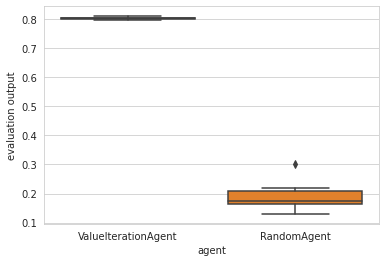

In [7]:
from rlberry.manager import AgentManager, evaluate_agents

# Define parameters
vi_params = {'gamma':0.1, 'epsilon':1e-3}

# Create AgentManager to fit 4 agents using 1 job
vi_stats = AgentManager(
    ValueIterationAgent,
    (env_ctor, env_kwargs),
    fit_budget=0,
    eval_kwargs=dict(eval_horizon=20),
    init_kwargs=vi_params,
    n_fit=4)
vi_stats.fit()

# Create AgentManager for baseline
baseline_stats = AgentManager(
    RandomAgent,
    (env_ctor, env_kwargs),
    fit_budget=0,
    eval_kwargs=dict(eval_horizon=20),
    n_fit=1)
baseline_stats.fit()

# Compare policies using 10 Monte Carlo simulations
output = evaluate_agents([vi_stats, baseline_stats], n_simulations=10)


Connected to temp/stats_ValueIterationAgent_1632497313/data_1403605487026081632497313.db (sqlite3 version = 2.6.0)


[I 2021-09-24 17:28:36,858] A new study created in RDB with name: no-name-0ac07548-ad2e-4b20-bf6d-93034c98ae9f
[INFO] Sucessful call to AgentHandler.dump() for <class '__main__.ValueIterationAgent'> 
[INFO] Sucessful call to AgentHandler.dump() for <class '__main__.ValueIterationAgent'> 
[INFO] Sucessful call to AgentHandler.dump() for <class '__main__.ValueIterationAgent'> 
[INFO] Sucessful call to AgentHandler.dump() for <class '__main__.ValueIterationAgent'> 
[INFO] Saved AgentManager(ValueIterationAgent) using pickle. 
[INFO] Training AgentManager for optim...  
[INFO] Sucessful call to AgentHandler.dump() for <class '__main__.ValueIterationAgent'> 
[INFO] ... trained! 
[INFO] Sucessful call to AgentHandler.load() for <class '__main__.ValueIterationAgent'> 
[I 2021-09-24 17:28:37,163] Trial 0 finished with value: 0.9199999999999999 and parameters: {'gamma': 0.75}. Best is trial 0 with value: 0.9199999999999999.
[INFO] Training AgentManager for optim...  
[INFO] Sucessful call to Ag

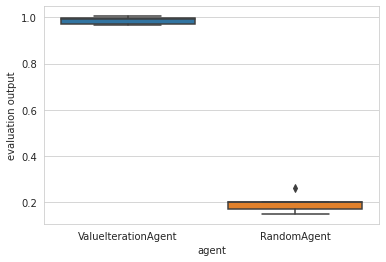

In [8]:
# The value of gamma above makes our VI agent quite bad! Let's optimize it.
vi_stats.optimize_hyperparams(n_trials=30, timeout=30, n_fit=1, sampler_method='random', pruner_method='none')

# fit with optimized params
vi_stats.fit()

# ... and see the results
output = evaluate_agents([vi_stats, baseline_stats])


In [9]:
# clear generated data
vi_stats.clear_output_dir()
baseline_stats.clear_output_dir()